# variable

In [1]:
#source /export/ciao/bin/ciao.bash -o
PFILES="./param;$ASCDS_INSTALL/param:$ASCDS_INSTALL/contrib/param"
mkdir -p ./param
ASCDS_WORK_PATH=./


In [2]:
/bin/rm -rf 635
download_chandra_obsid 635 evt2,asol,msk,bpix
mv -fv 635/*/*fits.gz .
gunzip -f *fits.gz


  Type     Format      Size  0........H.........1  Download Time Average Rate
  ---------------------------------------------------------------------------
  asol     fits       22 Mb  ####################          < 1 s  91621.0 kb/s
  evt2     fits       17 Mb  ####################          < 1 s  90806.5 kb/s
  bpix     fits       83 Kb  ####################          < 1 s  5906.9 kb/s
  msk      fits        5 Kb  ####################          < 1 s  464.0 kb/s

      Total download size for ObsId 635 = 39 Mb
      Total download time for ObsId 635 = < 1 s

'635/primary/acisf00635N005_evt2.fits.gz' -> './acisf00635N005_evt2.fits.gz'
'635/primary/acisf00635_000N005_bpix1.fits.gz' -> './acisf00635_000N005_bpix1.fits.gz'
'635/primary/pcadf00635_000N001_asol1.fits.gz' -> './pcadf00635_000N001_asol1.fits.gz'
'635/secondary/acisf00635_000N005_msk1.fits.gz' -> './acisf00635_000N005_msk1.fits.gz'


## Source

In [3]:
cat << EOM > src.reg 
# Region file format: CIAO version 1.0
circle(4161.3752,3573.2228,10)
EOM


[1] 8242
[1]+  Done                    ds9 acisf00635N005_evt2.fits -pan to 4153.5 3569.5 physical -bin factor 1 -zoom 2 -scale log -region src.reg -saveimage png ds9_01.png


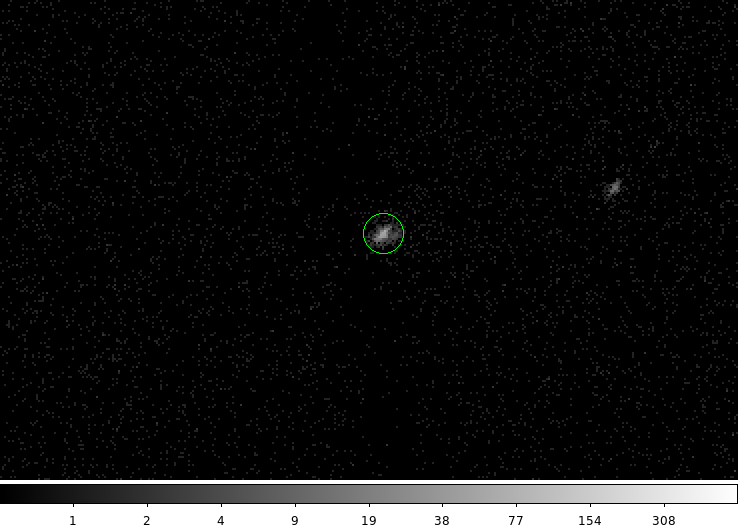

In [4]:
ds9 acisf00635N005_evt2.fits \
  -pan to 4153.5 3569.5 physical \
  -bin factor 1 -zoom 2 \
  -scale log \
  -region src.reg \
  -saveimage png ds9_01.png &
sleep 10
xpaset -p ds9 quit

display < ds9_01.png

## Setup ardlib

In [5]:
punlearn ardlib
acis_set_ardlib acisf00635_000N005_bpix1.fits abs-

Updated ardlib parameter file: /proj/sds/Staff/kjg/Threads/variable/param/ardlib.par
  AXAF_ACIS0_BADPIX_FILE -> acisf00635_000N005_bpix1.fits[BADPIX0]
  AXAF_ACIS1_BADPIX_FILE -> acisf00635_000N005_bpix1.fits[BADPIX1]
  AXAF_ACIS2_BADPIX_FILE -> acisf00635_000N005_bpix1.fits[BADPIX2]
  AXAF_ACIS3_BADPIX_FILE -> acisf00635_000N005_bpix1.fits[BADPIX3]
  AXAF_ACIS4_BADPIX_FILE -> CALDB
  AXAF_ACIS5_BADPIX_FILE -> CALDB
  AXAF_ACIS6_BADPIX_FILE -> acisf00635_000N005_bpix1.fits[BADPIX6]
  AXAF_ACIS7_BADPIX_FILE -> CALDB
  AXAF_ACIS8_BADPIX_FILE -> CALDB
  AXAF_ACIS9_BADPIX_FILE -> CALDB


## Run dither_region

In [6]:
punlearn dither_region
pset dither_region infile=pcadf00635_000N001_asol1.fits
pset dither_region region="region(src.reg)"
pset dither_region maskfile=acisf00635_000N005_msk1.fits
pset dither_region outfile=fracarea.fits
dither_region mode=h clob+

In [7]:
dmlist fracarea.fits cols

 
--------------------------------------------------------------------------------
Columns for Table Block AREAFRACTION
--------------------------------------------------------------------------------
 
ColNo  Name                 Unit        Type             Range
   1   TIME                 s            Real8          72039163.6412879974: 72141147.5575280041 Time
   2   EQPOS(RA,DEC)        deg          Real8          -360.0:      360.0   Sky Position
   3   ROLL                 deg          Real8          -Inf:+Inf            Roll angle
   4   FRACAREA                          Real8          -Inf:+Inf            Fraction area
   5   AREA_CHIP_FRAC[10]                Real8(10)      -Inf:+Inf            Region Area Fraction per chip
   6   DELTA_T              s            Real8          -Inf:+Inf            Time
   7   CHIP_FRAC_TIME[10]                Real8(10)      -Inf:+Inf            Fraction of ontime per chip
   8   STATUS                            Bit[8]                      

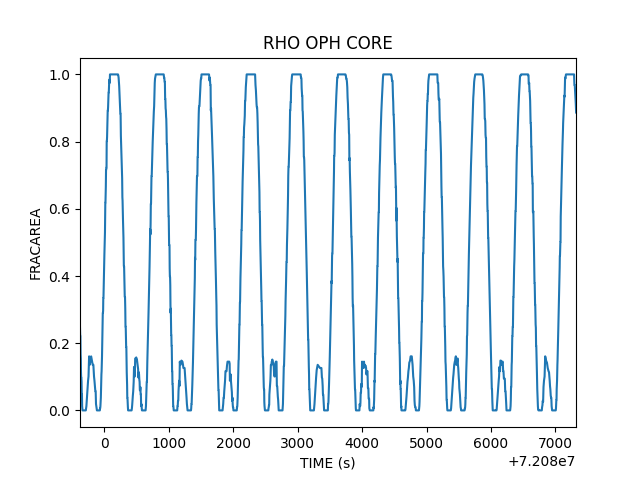

In [8]:
cat << EOM > c1.py
from pycrates import read_file
import matplotlib.pylab as plt

tab = read_file("fracarea.fits")
xx = tab.get_column("time").values
yy = tab.get_column("fracarea").values

plt.plot(xx,yy,marker="None")
plt.xlim(72079620, 72087320)
plt.xlabel("TIME (s)")
plt.ylabel("FRACAREA")
plt.title("RHO OPH CORE")
plt.savefig("chips_01.png")
EOM

python c1.py
display < chips_01.png

## Scale Area by DTF

In [9]:
dtf=`dmkeypar acisf00635N005_evt2.fits DTCOR echo+`
echo $dtf

0.98733739787229


In [10]:
dmtcalc "fracarea.fits[cols time,fracarea]" dtf_fracarea.fits \
  expression="dtf=(${dtf}*fracarea)" clob+

## Run gl-vary

In [11]:
pset glvary infile="acisf00635N005_evt2.fits[sky=region(src.reg),ccd_id=3]"
pset glvary effile=dtf_fracarea.fits
pset glvary outfile=gl_prob.fits
pset glvary lcfile=lc_prob.fits
glvary mode=h clob+

## Examing output

In [12]:
dmlist gl_prob.fits header | grep -i variab

0008 ODDS                       155.1249009276           Real8        Odds for variable signal 10Log
0009 PROB                         1.0                    Real8        Probability of variable signal
0014 VARINDEX             10                             Int4         Variability index


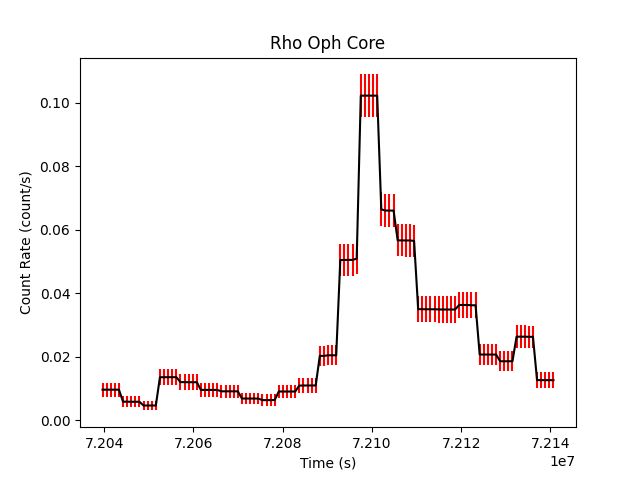

In [13]:
cat << EOM > c2.py

from pycrates import read_file
import matplotlib.pylab as plt

tab = read_file("lc_prob.fits")
xx = tab.get_column("Time").values
yy = tab.get_column("COUNT_RATE").values
ye = tab.get_column("COUNT_RATE_ERR").values

plt.errorbar(xx,yy,yerr=ye, ecolor="red", color="black")
plt.xlabel("Time (s)")
plt.ylabel("Count Rate (count/s)")
plt.title("Rho Oph Core")

plt.savefig("chips_02.png")
EOM

python c2.py
display < chips_02.png

---
## Without dither_region

In [14]:
pset glvary infile="acisf00635N005_evt2.fits[sky=region(src.reg),ccd_id=3]"
pset glvary effile=
pset glvary outfile=gl_prob_nodr.fits
pset glvary lcfile=lc_prob_nodr.fits
glvary mode=h clob+

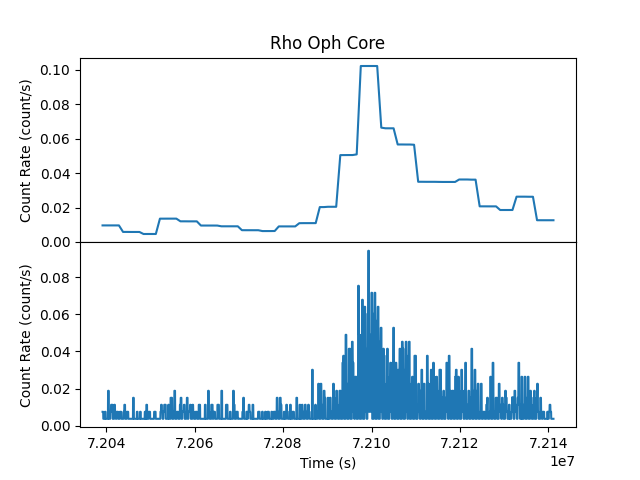

In [15]:
cat << EOM > c3.py
from pycrates import read_file
import matplotlib.pylab as plt

plt.subplot(2,1,1)
plt.subplots_adjust(hspace=0)

tab = read_file("lc_prob.fits")
xx = tab.get_column("Time").values
yy = tab.get_column("COUNT_RATE").values

plt.plot(xx,yy)
plt.ylabel("Count Rate (count/s)")
plt.title("Rho Oph Core")

plt.subplot(2,1,2)
tab = read_file("lc_prob_nodr.fits")
xx = tab.get_column("Time").values
yy = tab.get_column("COUNT_RATE").values
plt.plot(xx,yy)
plt.ylabel("Count Rate (count/s)")
plt.xlabel("Time (s)")

plt.savefig("chips_03.png")
EOM

python c3.py
display < chips_03.png

# Cleanup


In [16]:
/bin/rm -rf 635
/bin/rm -f acisf* pcadf* 
